# **Custom Dataset Classification (Advance Version)**
## การแยกประเภทของภาพแบบ Dataset กำหนดเอง ขั้นสูง
###สำหรับ MNIST Dataset พื้นฐาน ให้ไปที่ [ลิงก์นี้](https://colab.research.google.com/drive/1k_DPL60Xmp3B8tw8Edr83A9R7fCXz_Nm?usp=sharing#scrollTo=FD9ga62_3FqA) แทน

ออกแบบโดย Leagues of Code TH

อัพเดทล่าสุด 6 ตุลาคม 2566

# **1 Dataset ที่จะใช้**
เป็น Dataset แยกพันธุ์ของสุนัขจำนวน 6 สายพันธุ์ (รูปด้านล่างไม่ใช่รูปใน Dataset)
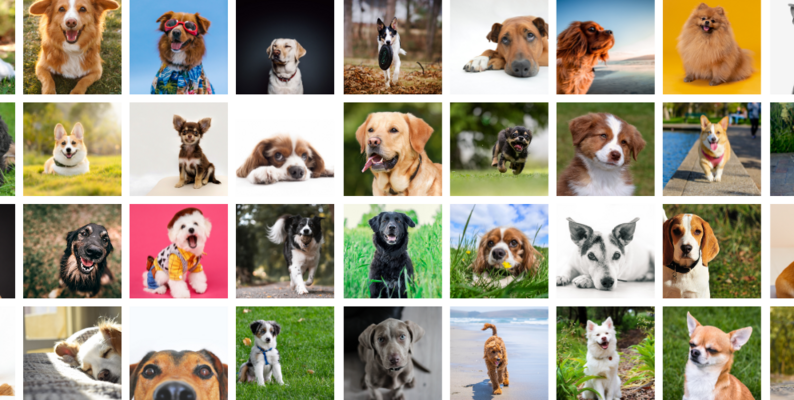

Dataset นี้ประกอบไปด้วย

1. Bedlington_terrier | 136 รูป
2. Bernese_mountain_dog | 131 รูป
3. Dandie_Dinmont | 115 รูป
4. Gordon_setter | 116 รูป
5. Ibizan_hound | 124 รูป
6. Norwegian_elkhound | 130 รูป

ซึ่งเอามาจาก https://www.kaggle.com/code/wuttipats/6-dog-breed-files-filter และจำเป็นต้องดาวน์โหลดพร้อมอัพโหลดไปใน Google Colab ใน folder `content/data` ให้เรียบร้อยก่อน

#  **2 Import Library ที่เราต้องใช้**

In [ ]:
!unzip

In [ ]:
!pip install -q lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger

import torch
from torch.nn import CrossEntropyLoss
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset

from torchvision.transforms.functional import pil_to_tensor

from torchvision.datasets import MNIST
import torchvision.transforms as TF

from PIL import Image

import wandb
import os

In [ ]:
from fastai.vision.all import *

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

torch.backends.deterministic = True

# **3 สร้าง Custom Dataset Class**

เนื่องจากว่าเราไม่ได้ใช้ MNIST dataset ซึ่งเป็น dataset สำเร็จรูปแล้ว เราจึงจำเป็นต้องสร้าง Dataset Class สำหรับ Custom Dataset ของเราโดยเฉพาะ เราจำเป็นต้องเขียนโดย Inherit มาจาก Dataset พร้อมทั้งมี 3 methods ดังนี้


---

**Required Methods for Custom Dataset**

1. **\_\_init\_\_(self)** - สำหรับ Initialize Custom Dataset เช่น Path ที่เก็บ Folder Dataset และรูปทั้งหมดเอาไว้, Augmentation เริ่มต้นที่เราต้องการ ฯลฯ

2. **\_\_len\_\_(self)** - ให้ return ความยาวของ Dataset เรา

3. **\_\_getitem\_\_(self, idx)** - รับค่า idx เข้าไป แล้วให้คืนค่ากลับมาเป็นอะไรก็ได้ที่จะเอาไว้สำหรับใช้ในการ Train ของเรา ส่วนใหญ่จะคืนค่ากลับมาเป็น tuple ความยาว 2 ที่ประกอบไปด้วย Raw Image (x) และ Label (y)



---

โดยลำดับของ folder dataset ของเราเป็นดังนี้
```
root
  |--- Bedlington_terrier
        |--- Bedlington_terrier_1.jpg
        |--- Bedlington_terrier_2.jpg
        .
        .
  |--- Bernese_mountain_dog
        |--- Bernese_mountain_dog_1.jpg
        |--- Bernese_mountain_dog_2.jpg
        .
        .
  .
  .
  |--- Norwegian_elkhound
        |--- Norwegian_elkhound_1.jpg
        |--- Norwegian_elkhound_2.jpg
        .
        .
        |--- Norwegian_elkhound_130.jpg
```
หากยังไม่เห็นภาพ ให้ศึกษา Custom Dataset Class ด้านล่างนี้ให้ถี่ถ้วน

In [ ]:
class DogClassificationDataset(Dataset):
    def __init__(self, root: str, transforms=TF.Compose([TF.ToTensor(), TF.Resize((240, 240)), TF.RandomRotation(10), TF.RandomPerspective(0.3, 0.25), TF.RandomHorizontalFlip()])):
        self.root = root
        self.all_images = []
        self.transforms = transforms
        for d in os.listdir(self.root):
            for img in os.listdir(os.path.join(self.root, d)):
                self.all_images.append(os.path.join(self.root, d, img))

        self.label_index_matcher = {'Bedlington': 0,
                                    'Bernese': 1,
                                    'Dandie': 2,
                                    'Gordon': 3,
                                    'Ibizan': 4,
                                    'Norwegian': 5,}
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):

        image_path = self.all_images[idx]
        label = self.label_index_matcher[image_path.split('/')[-1].split('_')[0]]

        image = Image.open(image_path)

        if self.transforms:
            image = self.transforms(image)

        return image, label


In [ ]:
dog_dataset = DogClassificationDataset('data')
len(dog_dataset)

752

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset=dog_dataset, lengths=[0.7, 0.2, 0.1])
print(f'Train Dataset Size: {len(train_dataset)}\nValidation Dataset Size:  {len(val_dataset)}\nTest Dataset Size: {len(test_dataset)}')

Train Dataset Size: 527
Validation Dataset Size:  150
Test Dataset Size: 75


LABEL tensor([5])
Image type:  <class 'torch.Tensor'>
torch.Size([1, 3, 240, 240])
torch.Size([3, 240, 240])


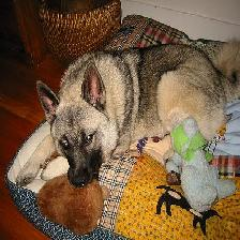

In [ ]:
# Create Inspector DataLoader
batch_size = 1
inspector_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Iterate over dataloader once
img, label = next(iter(inspector_loader))

print('LABEL', label)

print('Image type: ', type(img))


if batch_size == 1:
    # squeeze image from 4-Dimensional tensor to 3-Dimensional tensor
    print(img.shape)
    img = img.squeeze(0)
    print(img.shape)
    display(TF.ToPILImage()(img))

if 1 < batch_size < 12:
    for i in range(batch_size):
        display(TF.ToPILImage()(img[i]))
        print('\n')

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
class DogClassificationModel(nn.Module):
    def __init__(self, n_in=240*240, num_filters: list = [16,32], hidden_layer=64):
        super(DogClassificationModel, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=num_filters[1], kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 60 * 60, hidden_layer)  # 32 channels * 60x60 spatial size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer, 6)

        self.flatten = nn.Flatten()
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x))) # เข้า 3x240x240 ออก 16 x 120 x 120
        x = self.pool2(self.relu2(self.conv2(x))) # เข้า 16x120x120 ออก 32x60x60
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
x, y = next(iter(train_dataloader))
model = DogClassificationModel()
print(f'The shape of raw image tensors: {x.shape} \nAnd when raw image is fed through the model:  {model(x).shape}')

The shape of raw image tensors: torch.Size([16, 3, 240, 240]) 
And when raw image is fed through the model:  torch.Size([16, 6])


In [ ]:
class DogClassifier(pl.LightningModule):
    def __init__(self, architecture, lr, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Declare Model
        self.model = architecture

        # Learning Rate
        self.lr = lr

        # Define Loss function
        self.loss_fn = CrossEntropyLoss()

        # Save hyperparams for reproducibility
        self.save_hyperparameters()

    def forward(self, x):
        # feed x to model
        prediction = self.model(x)
        return prediction

    def configure_optimizers(self):
        # Use Adam as a optimizer
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        # x is our 4D tensor of raw images, y is 1D tensor of labels
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y) # Calculate loss
        self.log('training_loss', loss) # Logging loss function
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).sum() / len(y) # calculate accuracy
        self.log('val_loss', loss)
        self.log('val_acc', accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).sum() / len(y)  # calculate accuracy
        self.log('test_loss', loss)
        self.log('test_acc', accuracy)
        return loss



In [ ]:
# Declare neccessary info.

architecture = DogClassificationModel()
lr = 0.0001
max_epochs = 100

In [ ]:
# create wandb_logger object instance for logging
wandb_logger = WandbLogger(name='Trail_1', project='Dog breed Classification')

# declare lightning module for training
model = DogClassifier(architecture=architecture, lr=lr)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'architecture' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['architecture'])`.
  rank_zero_warn(


In [ ]:
# create trainer
trainer = pl.Trainer(max_epochs=max_epochs, logger=wandb_logger)

# train model with train_dataloader, val_dataloader
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | DogClassificationModel | 7.4 M 
1 | loss_fn | CrossEntropyLoss       | 0     
---------------------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.513    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type                   | Params
-------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the trainin

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.test(dataloaders=test_dataloader)
wandb.finish()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at ./Dog breed Classification/jt8pup8z/checkpoints/epoch=99-step=3200.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./Dog breed Classification/jt8pup8z/checkpoints/epoch=99-step=3200.ckpt
INFO: Loaded model weights from the checkpoint at ./Dog breed Classification/jt8pup8z/checkpoints/epoch=99-step=3200.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./Dog breed Classification/jt8pup8z/checkpoints/epoch=99-step=3200.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.47999998927116394    │
│         test_loss         │    2.7709145545959473     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,██▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▄▅█▆▆▆▆▆▆▆▆▇▅▆▇▇▆▆▆▆▆▆▆▆▆▅▆▅▆▆▆▆▆▆▆▆▆
val_loss,▃▃▂▂▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▅▅▆▆▆▆▇▇▇▇▇▇▇███
epoch,100
test_acc,0.48
test_loss,2.77091
trainer/global_step,3200
